# Chapter 3: Exploratory Data Analysis

## 0. Loading the data

The original dataset was downloaded from https://www.kaggle.com/yelp-dataset/yelp-dataset#yelp_academic_dataset_review.json. We uploaded it to our GDrive and proceed to mount it.

In [0]:
# Import libraries
import pandas as pd
from google.colab import drive

# Mount GDrive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


We load the reviews and business JSON. Review's JSON weights ~5GB, too much for our system, so we are going to load it by chunks. After the data is loaded, we merge them.

In [0]:
# Load the data into Pandas DataFrames
review_df_chunks = pd.read_json("/content/drive/My Drive/TFM/yelp_academic_dataset_review.json", lines=True, chunksize=2000000)
business_df = pd.read_json("/content/drive/My Drive/TFM/yelp_academic_dataset_business.json", lines=True)

# Merge reviews with business information. We will keep only the necessary columns
chunk_list = []

for chunk in review_df_chunks:
  # Joinby business_id
  chunk = chunk.merge(business_df, on="business_id",how="left")
  # Select necessary columns (attributes)
  chunk = chunk[["text","stars_x","categories"]]
  # Store clean chunk
  chunk_list.append(chunk)

# Final review store on a DataFrame
review_df = pd.concat(chunk_list)

# Show 5 rows as an example
review_df.head()

,text,stars_x,categories
0,Total bill for this horrible service? Over $8G...,1,"Fitness & Instruction, Doctors, Health & Medic..."
1,I *adore* Travis at the Hard Rock's new Kelly ...,5,"Beauty & Spas, Hair Stylists, Makeup Artists, ..."
2,I have to say that this office really has it t...,5,"Health & Medical, Cosmetic Dentists, Orthodont..."
3,Went in for a lunch. Steak sandwich was delici...,5,"Bars, Pubs, Nightlife, Tapas Bars, Restaurants"
4,Today was my second out of three sessions I ha...,1,"Teeth Whitening, Beauty & Spas"


We change the 'stars_x' column name to 'stars' for readability:

In [0]:
review_df = review_df.rename(columns={"stars_x":"stars"})

review_df.head()

,text,stars,categories
0,Total bill for this horrible service? Over $8G...,1,"Fitness & Instruction, Doctors, Health & Medic..."
1,I *adore* Travis at the Hard Rock's new Kelly ...,5,"Beauty & Spas, Hair Stylists, Makeup Artists, ..."
2,I have to say that this office really has it t...,5,"Health & Medical, Cosmetic Dentists, Orthodont..."
3,Went in for a lunch. Steak sandwich was delici...,5,"Bars, Pubs, Nightlife, Tapas Bars, Restaurants"
4,Today was my second out of three sessions I ha...,1,"Teeth Whitening, Beauty & Spas"


## 1. Topic distribution

The category column is a string with a list of all categories of reviews separated by a comma. For category counting, we split each category string of a row into a list of categories and append it to an auxiliary list. Then we will convert this list to a Pandas Series and count using its 'value_counts' method. Finally, we sort in a descending way. 

__Remark:__ We first drop all reviews whose business does not have any category (if there is any).

In [0]:
# Import regex library to find words in a category string
import re

# Drop all reviews whose business does not have any category
review_df = review_df.dropna(axis=0,subset=["categories"])

# Initialize list with rows from categories' column
categories_count = review_df['categories'].values
# Find categories in category string and append it to an auxiliary list
categories_count = [y for x in categories_count for y in re.findall("[^,\s][^\,]*[^,\s]*", x)]
# Transform auxiliary list to a Pandas Series
categories_count = pd.Series(categories_count)
# Use value_counts method and sort
categories_count = categories_count.value_counts().sort_values(ascending=False)

We can now plot a bar chart with the top 10 categories counted:

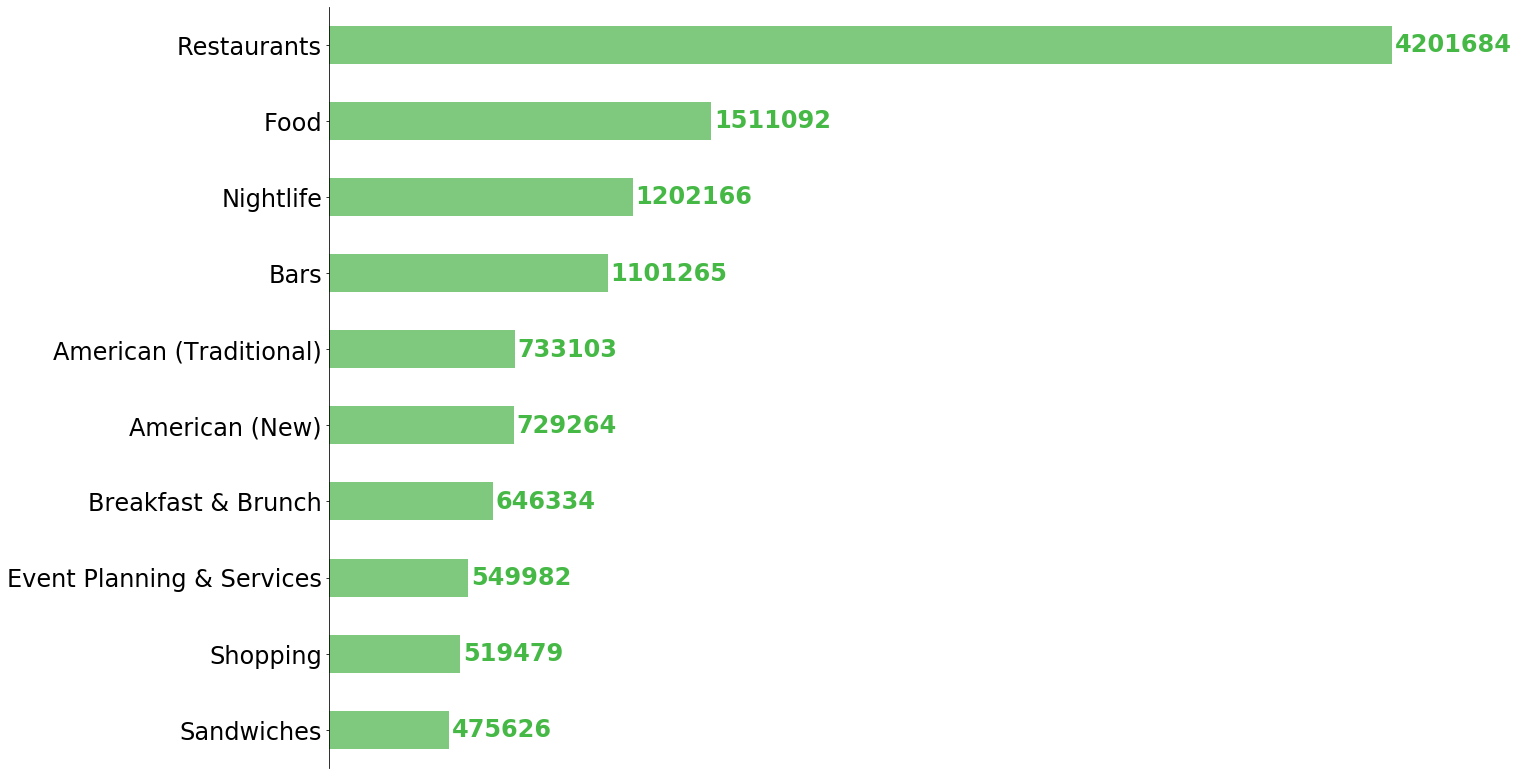

In [0]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Select top 10 categories and do a bar chart. For aesthetic purposes we plot it horizontally
ax = categories_count[:10].plot.barh(colormap="Accent", figsize=(20,14))
# Next steps are only done for aesthetic
# Invert y axis
ax.invert_yaxis()
# Remove x axis
ax.get_xaxis().set_visible(False)
# Remove top, right and bottom borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Make y legend bigger
ax.yaxis.set_tick_params(labelsize=24)
# Plot count number at the left of the bar
for i, v in enumerate(categories_count[:10]):
    ax.text(v + 10000, i, str(v), va='center', color="#46B846", size=24, fontweight='bold')

### 1.1.  Selecting restaurants who serve traditional american food.

We can select only the rows (reviews) who come from restaurants who at least serve traditional american food with Pandas' string method:

In [0]:
# Select restaurants whose category contains 'American (Traditional)'
review_df = review_df.loc[review_df['categories'].str.contains('American (Traditional)', regex=False)]

# Show 5 rows as an example
review_df.head()

,text,stars,categories
48,"notes: 1 visit, breakfast/lunch\noverall: Exce...",4,"American (New), Buffets, Restaurants, American..."
53,We had dinner here and the food was excellent ...,4,"Italian, Restaurants, Bars, Nightlife, America..."
56,We went here Saturday for dinner. We had a 2-1...,3,"American (New), Buffets, Restaurants, American..."
72,received a mailer and thought okay let's go. ...,4,"Restaurants, Bars, Nightlife, American (Tradit..."
78,ooooooh yummy. i'm a red meat eating midweste...,4,"Seafood, Steakhouses, American (Traditional), ..."


## 2. Sentiment distribution

Recall that a review's sentiment is given by the 'stars' attribute. 'stars' are integers that range from 1 to 5. It is then a categorical attribute, and its distribution can be visualized like in the previous section. 'stars' is already a clean attribute, so we can directly apply Pandas' 'groupby' and 'count' methods to get 'stars' count:

In [0]:
# Group DataFrame by stars and count number of occurrencies. We just need the stars column and
# any another one to apply 'groupby', so we select these two for a better efficiency
stars_count = review_df[['text', 'stars']].groupby(by=['stars']).count()

We plot like in the previous section:

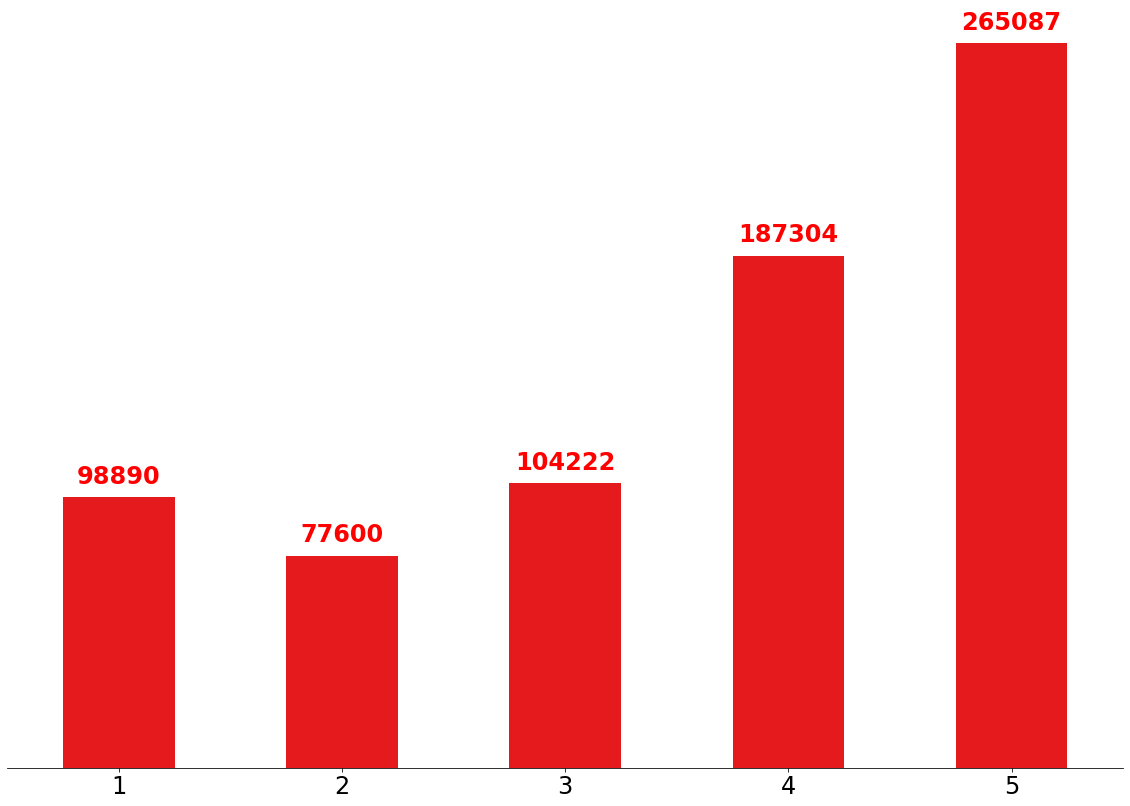

In [0]:
# Do a bar plot
ax = stars_count.plot.bar(colormap="Set1", figsize=(20,14), rot=0)
# Next steps are only done for aesthetic
# Remove y axis
ax.get_yaxis().set_visible(False)
# Remove x label text
ax.set_xlabel("")
# Remove legend
ax.get_legend().remove()
# Remove top, right and left borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# Make x legend text bigger
ax.xaxis.set_tick_params(labelsize=24)
# Plot count number at the top of the bar
for i, v in zip(stars_count.index,stars_count.values):
    ax.text(i - 1, v[0] + 5000, str(v[0]), ha="center", color='red', fontweight='bold', size=24)

## 3. Text study

### 3.1. Descriptive study

We are first going to count the string length of each review. We store string length in a column:

In [0]:
# Create string length column
review_df['str len'] = review_df['text'].str.len()

# Show 5 as an example
review_df.head()

,text,stars,categories,str len
48,"notes: 1 visit, breakfast/lunch\noverall: Exce...",4,"American (New), Buffets, Restaurants, American...",893
53,We had dinner here and the food was excellent ...,4,"Italian, Restaurants, Bars, Nightlife, America...",128
56,We went here Saturday for dinner. We had a 2-1...,3,"American (New), Buffets, Restaurants, American...",732
72,received a mailer and thought okay let's go. ...,4,"Restaurants, Bars, Nightlife, American (Tradit...",442
78,ooooooh yummy. i'm a red meat eating midweste...,4,"Seafood, Steakhouses, American (Traditional), ...",481


To get a summary of all reviews statistics, we can use Pandas' 'describe' method:

In [0]:
review_df['str len'].describe()

count    733103.000000
mean        577.819803
std         535.667847
min           1.000000
25%         228.000000
50%         409.000000
75%         739.000000
max        5000.000000
Name: str len, dtype: float64

For each star number, we can do the same with a previous 'groupby':

In [0]:
review_df[['stars','str len']].groupby(by='stars').describe()

str len                                                           
          count        mean         std   min    25%    50%    75%     max
stars                                                                     
1       98890.0  674.841066  609.921269   1.0  274.0  490.0  858.0  5000.0
2       77600.0  722.904678  611.481274   5.0  310.0  548.0  933.0  5000.0
3      104222.0  675.636008  572.031130   3.0  287.0  512.0  880.0  5000.0
4      187304.0  589.630841  525.926519  10.0  238.0  429.0  766.0  5000.0
5      265087.0  452.352035  438.118256   1.0  185.0  313.0  552.0  5000.0

Finally, we discard reviews shorter than 10 characters and show how many reviews will be discarded:

In [0]:
# Print number of reviews shorter than 10 characters
print('The number of reviews with less than 10 characters is', len(review_df.loc[review_df['str len'] < 10]))

# Discard reviews shorter than 10 characters
review_df = review_df.loc[review_df['str len'] >= 10]

The number of reviews with less than 10 characters is 21


## 3.2. Word Cloud

To create a Word Cloud we will use the WordCloud library. If it is not installed on your system, you should run the following line:

In [0]:
pip install wordcloud

WordCloud takes as input a unique string, so we will have to join all reviews into a sole, big string. We will use Python built-in 'join' string method. Note that we make a Word Cloud for each star number.

__Remark:__ For a better representation, stop words will be removed using WordCloud's own stop words list.



In [0]:
# Import wordcloud method and stop words list from WordCloud library
from wordcloud import WordCloud, STOPWORDS

# Create unique string for each category
review_text = []

for i in range(5):
  review_text.append(" ".join(review for review in review_df['text'].loc[review_df['stars'] == i+1]))

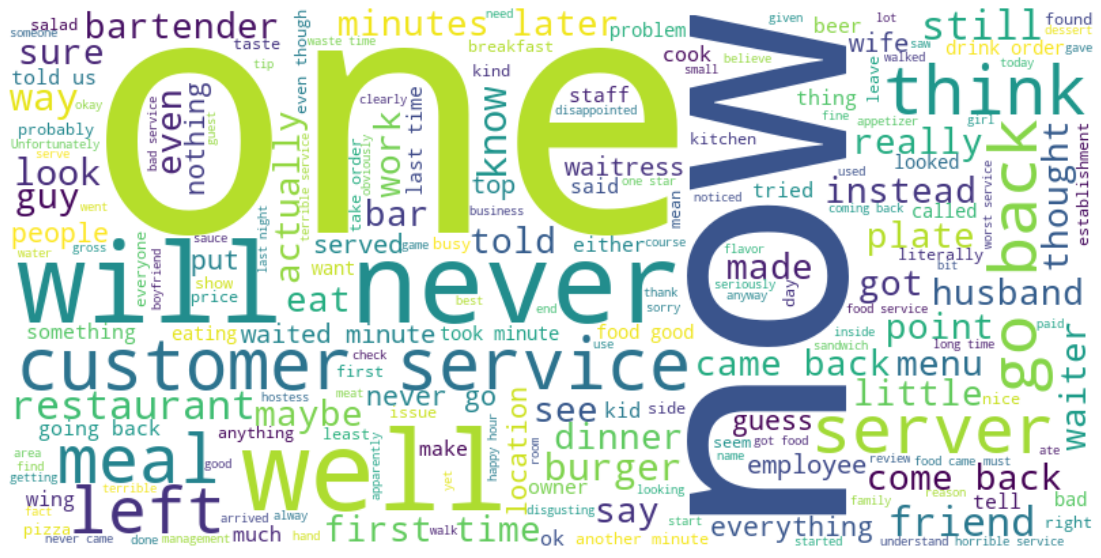

In [0]:
# Create and generate a word cloud image for reviews with 1 star
wordcloud_1 = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(review_text[0])

# Display the generated image
plt.figure(figsize = (20,10))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

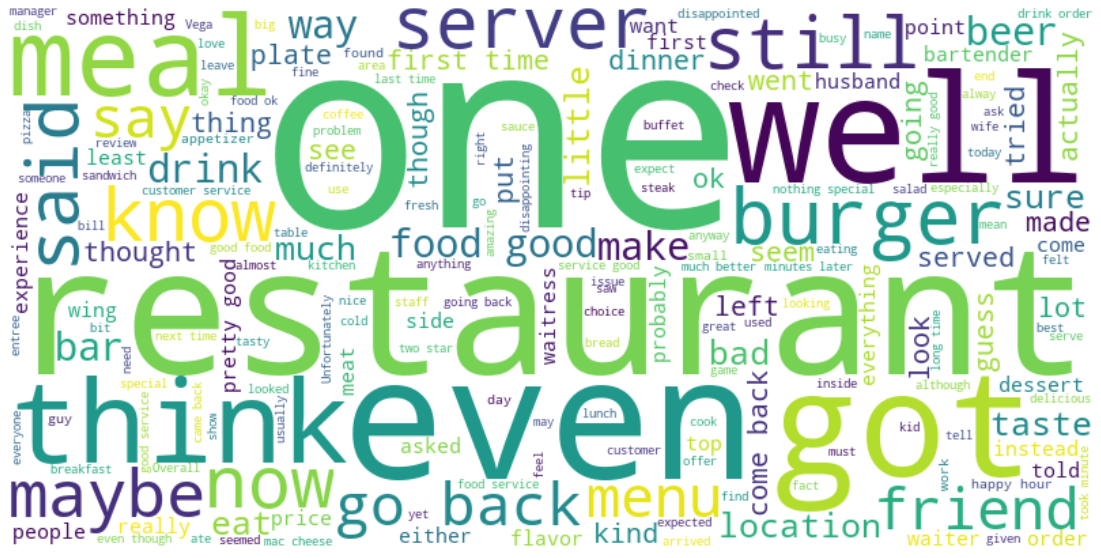

In [0]:
# Create and generate a word cloud image for reviews with 2 stars
wordcloud_2 = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(review_text[1])

# Display the generated image
plt.figure(figsize = (20,10))
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")
plt.show()


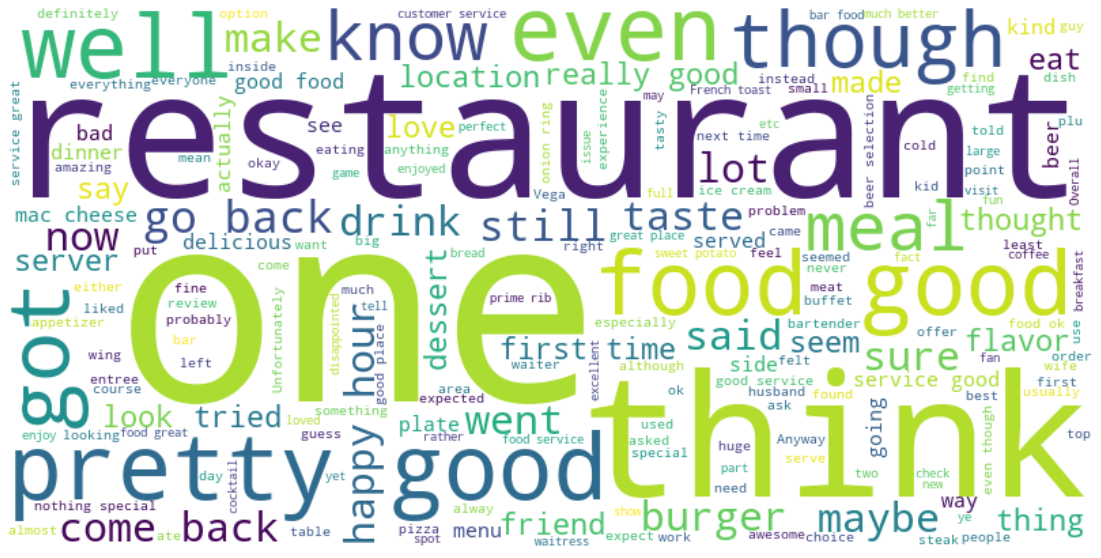

In [0]:
# Create and generate a word cloud image for reviews with 3 stars
wordcloud_3 = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(review_text[2])

# Display the generated image
plt.figure(figsize = (20,10))
plt.imshow(wordcloud_3, interpolation='bilinear')
plt.axis("off")
plt.show()

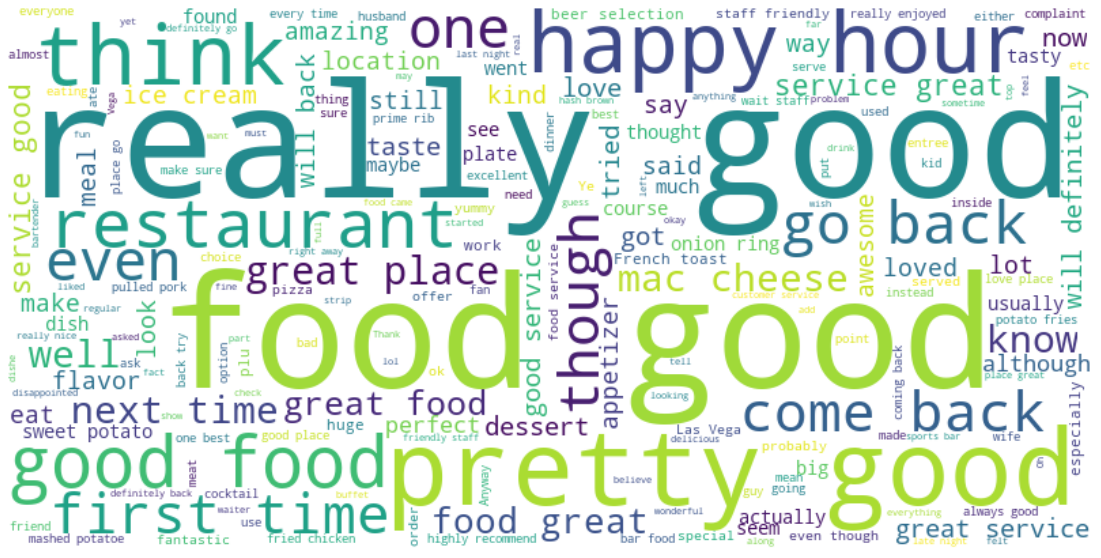

In [0]:
# Create and generate a word cloud image for reviews with 4 stars
wordcloud_4 = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(review_text[3])

# Display the generated image
plt.figure(figsize = (20,10))
plt.imshow(wordcloud_4, interpolation='bilinear')
plt.axis("off")
plt.show()

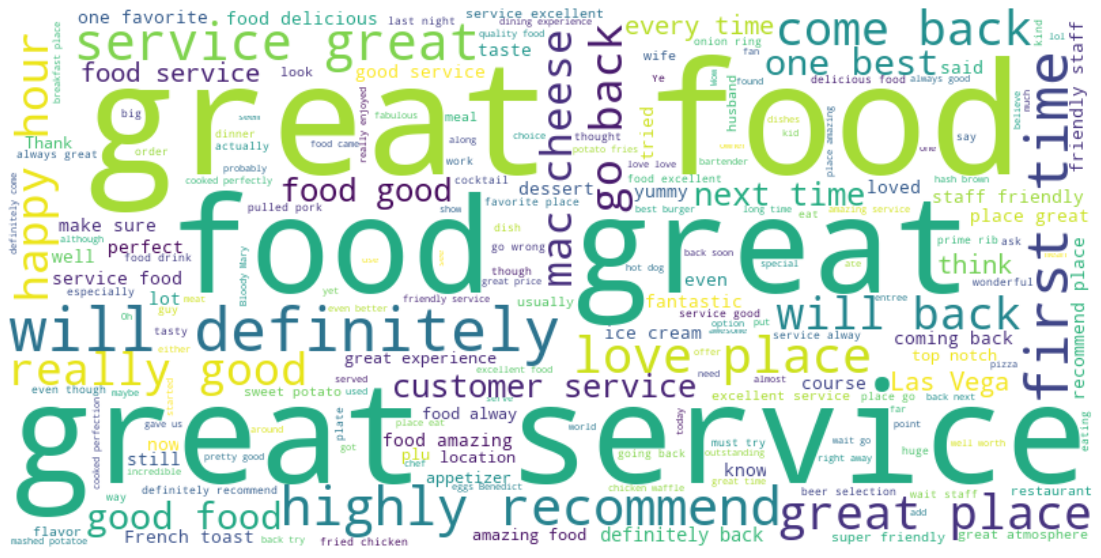

In [0]:
# Create and generate a word cloud image for reviews with 5 stars
wordcloud_5 = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(review_text[4])

# Display the generated image
plt.figure(figsize = (20,10))
plt.imshow(wordcloud_5, interpolation='bilinear')
plt.axis("off")
plt.show()

## 4. Dataset export

After our EDA and small cleaning, our dataset is ready to be exported. Dataset balancing is needed, so in order to reduce disk space, we are going to do it before exporting. We balance the dataset so each star class has 6000 instances. 

__Remark:__ We randomly select 6000 instances without replacement.

In [0]:
# Sample 20000 instances without replacement from 1 star reviews and store it in a new DataFrame
final_review_df = review_df.loc[review_df['stars'] == 1].sample(n=6000, replace=False)

# Sample 20000 instances without replacement from rest of star number reviews and store it in previous DataFrame
for i in range(2,6):
  final_review_df = final_review_df.append(review_df.loc[review_df['stars'] == i].sample(n=6000, replace=False))

Finally, we select the attributes we are going to use and export them to a CSV file.

In [0]:
# Select necessary attributes
final_review_df = final_review_df[['text', 'stars']]

# Export to csv without index
final_review_df.to_csv('/content/drive/My Drive/TFM/yelp_reviews.csv', index=False)